In [153]:
# Author: Sabin, 9/6/2023
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy

Now, we solve the previous problem, but with the initial temperature and crystallinity profiles being sinusoidal. Here we want to see whether or not solidification at the crest is faster compared than that at the trough. Also, we assume that the solidification proceeds only in the forward direction. Once we verify that we get what is expected, then we will allow crystal grow in all possible directions.

In [154]:
def cdf_bulk(my_arr, pos_2d):
    '''to find 2d central difference 2nd derivative at each point except the boundry points'''
    x_pos, y_pos = pos_2d[0], pos_2d[1]
    
    d_dx2 = (1/delx**2)*(my_arr[x_pos+1, y_pos]+my_arr[x_pos-1, y_pos]-2*my_arr[x_pos, y_pos])
    d_dy2 = (1/dely**2)*(my_arr[x_pos, y_pos+1]+my_arr[x_pos, y_pos-1]-2*my_arr[x_pos, y_pos])
    
    return d_dx2+d_dy2

def cdf_boundary_right(my_arr, pos_2d):
    '''at the upper lateral boundary points using PBC'''
    x_pos, y_pos = pos_2d[0], pos_2d[1]
    
    d_dx2 = (1/delx**2)*(my_arr[x_pos+1, y_pos]+my_arr[x_pos-1, y_pos]-2*my_arr[x_pos, y_pos])
    d_dy2 = (1/dely**2)*(my_arr[x_pos, 0]+my_arr[x_pos, y_pos-1]-2*my_arr[x_pos, y_pos]) #pbc
    
    return d_dx2+d_dy2

def cdf_boundary_left(my_arr, pos_2d):
    '''at the upper lateral boundary points using PBC'''
    x_pos, y_pos = pos_2d[0], pos_2d[1]
    
    d_dx2 = (1/delx**2)*(my_arr[x_pos+1, y_pos]+my_arr[x_pos-1, y_pos]-2*my_arr[x_pos, y_pos])
    d_dy2 = (1/dely**2)*(my_arr[x_pos, 1]+my_arr[x_pos, y_pos-1]-2*my_arr[x_pos, y_pos]) #pbc
    
    return d_dx2+d_dy2

## The two lateral ends are connected, so the points at the edge are exactly the same, so grids at one of the edge are just
## place holders - I compute the right edge, and immediately copy that to the left edge. Caution: make sure their values are 
## the same when applying the perturbation as well

In [155]:
# Parameters

#alpha = 1
lam = 5.0 #L/C(T_solid-T_liquid)

delx = 0.1
dely = delx
delt = (delx**2)/8

T_solid = 0 # solid temperature on the left, melting temperature
T_liquid = -1 # liquid temperature on the right, supercooled

In [156]:
# Initial configuration
length = 100 # no. of grids along length
width = 100 # along width

temp_array = np.zeros((length, width)) # initialize temperature array
initial_boundary0 = 20*delx # ref

L_x = (width-1)*delx #physical width
n_wave = 5
amp = 6.1*delx
k = ((2*np.pi)/L_x)*n_wave

x_position = np.arange(0, L_x+delx, delx)
initial_boundary = initial_boundary0+amp*np.sin(k*x_position)

#print(initial_boundary)

#temp_drop_range = 1 # temp linearly goes from L_solid to L_liquid across five grid points

for j in range(width):
    for i in range(length):
        y_position = i*delx
        if y_position < initial_boundary[j]:
            temp_array[i,j] = T_solid
        else:
            temp_array[i,j] = T_liquid
            
#        else:
#            grid_distance = (y_position - initial_boundary[j])/(temp_drop_range*delx)
#            if grid_distance <= 1:
#                temp_array[i,j] = T_solid - (T_solid-T_liquid)*(y_position - initial_boundary[j])/(temp_drop_range*delx)
#            else:
#                temp_array[i,j] = T_liquid
                
        
        
#print(temp_array)

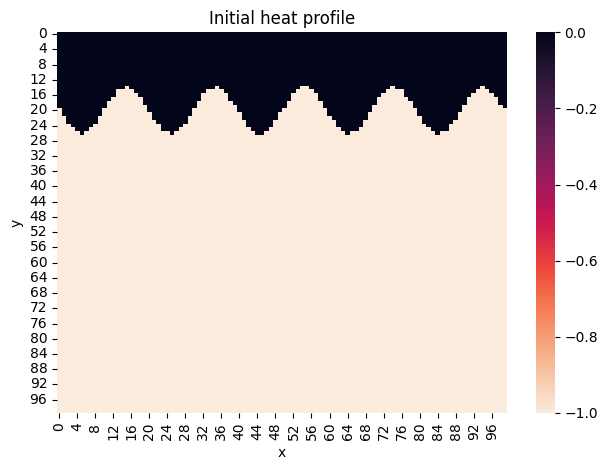

In [157]:
# heat map
# diffuse temperature boundary - initial condition
ax = sns.heatmap(temp_array, cmap = sns.cm.rocket_r)
#cmap = sns.cm.rocket_r
plt.title('Initial heat profile')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [158]:
phi_array = np.zeros((length, width))

for i in range(length):
    for j in range(width):
        temp = temp_array[i,j]
        if temp == T_solid:
            phi_array[i,j] = 1     

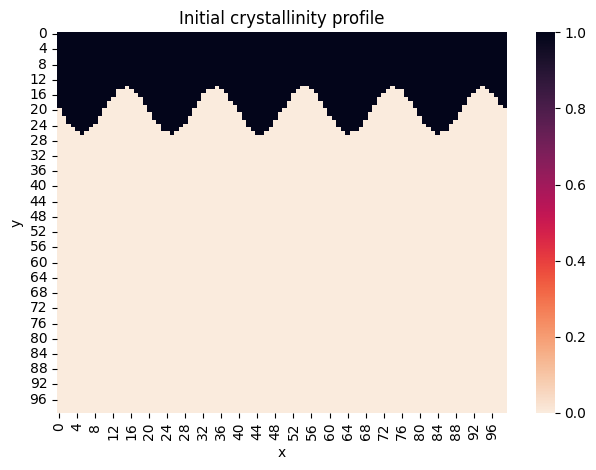

In [159]:
# plot initial liquid fraction
ax = sns.heatmap(phi_array, cmap = sns.cm.rocket_r)
plt.title('Initial crystallinity profile')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

Note that we take the amplitude somewhat large. It is beacause due to the granularity of the grids, the variation of curvature can't be correctly realized if the amplitude is too small. 

In [160]:
## Now find time evolution
#print(temp_array.shape)

temp_profiles_list = [temp_array]
phi_profiles_list = [phi_array]

phi_array[20,0]
#print(initial_boundary)

0.0

In [161]:
new_constant = 1.0/lam
total_time_steps = 1500

#x_position = np.arange(0, L_x+delx, delx)
boundary = [initial_boundary]
time_lis = [0]
int_boundary = [0]
smooth_boundary = [0]

for t in range(1,total_time_steps+1):
    #print(t)
    time_lis.append(t*delt)
    #initialize dphi_dt array
    dphi_dt_array = np.zeros((length, width))
    dT_dt_array = np.zeros((length, width))
    temp_gap = np.zeros((length, width))
    phi0 = np.zeros((length, width))
    
    #Calculate temp gap
    for i in range(1, length-1):
        for j in range(0, width):
            if phi_array[i-1, j] == 1 and phi_array[i, j] == 0:
                temp_gap[i,j] = T_solid - temp_array[i, j]
                phi0[i,j] = temp_gap[i,j]*new_constant
            
    ## bulk
    for i in range(1,length-1):
        for j in range(width):
            if phi_array[i-1, j] == 1 and phi_array[i, j] < 1:
                #print(i)
                temp_array[i, j] = T_solid
                
    for i in range(1, length-1):
        for j in range(1, width-1):
            if phi_array[i-1, j] == 1 and phi_array[i, j] < 1:
                dphi_dt_array[i,j] = abs(-1/lam*cdf_bulk(temp_array, [i,j]))  #+ temp_gap[i,j]*new_constant/delt)
                
            else:
                dT_dt_array[i,j] = cdf_bulk(temp_array, [i,j]) 
                
        ## lateral
    for i in range(1, length-1):
        if phi_array[i-1, 0] == 1 and phi_array[i, 0] < 1:
            dphi_dt_array[i,0] = -1/lam*cdf_boundary_left(temp_array, [i,0]) #+ temp_gap[i,0]*new_constant/delt
        else:
            dT_dt_array[i,0] = cdf_boundary_left(temp_array, [i,0])
                
        if phi_array[i-1, width-1] == 1 and phi_array[i, width-1] < 1:
            dphi_dt_array[i, width-1] = -1/lam*cdf_boundary_right(temp_array, [i,width-1]) #+ temp_gap[i,width-1]*new_constant/delt
        else:
            dT_dt_array[i,width-1] = cdf_boundary_right(temp_array, [i, width-1])
                
    temp_array = temp_array + delt*dT_dt_array
    phi_array = phi_array + delt*dphi_dt_array + phi0
    
    for i in range(1,length-1):
        for j in range(width):
            if phi_array[i,j] > 1:
                phi_array[i,j]=1
                
            if dphi_dt_array[i,j]>0 or phi_array[i,j]==1: ### check this again, need to make sure that I am not over constraining
                temp_array[i,j] = T_solid
                temp_array[i-1,j] = T_solid
                
    boundary_list = []
    
    for j in range(width):
        seq = phi_array[:,j]
        for ind, elem in enumerate(seq):
            if elem < 1:
                boundary_list.append(ind*delx) # this needs to be verified
                current_phi = elem
                break
    if t%10 == 0:          
        boundary.append(boundary_list)
        
    int_boundary.append(boundary_list[0]-initial_boundary0)
    smooth_boundary.append(boundary_list[0]-initial_boundary0 + elem*delx)
    #print(boundary_list)

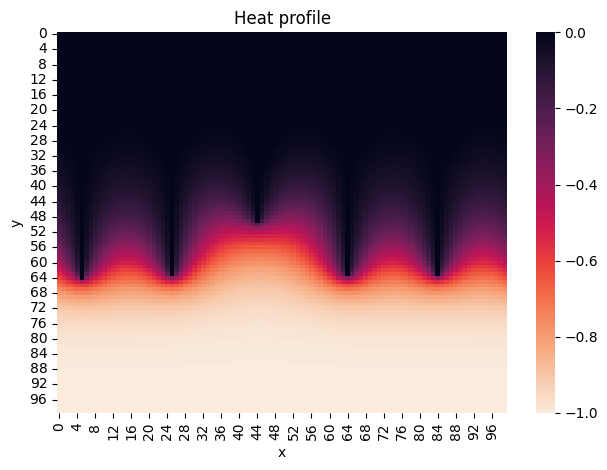

In [162]:
ax = sns.heatmap(temp_array, cmap = sns.cm.rocket_r)
plt.title('Heat profile')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

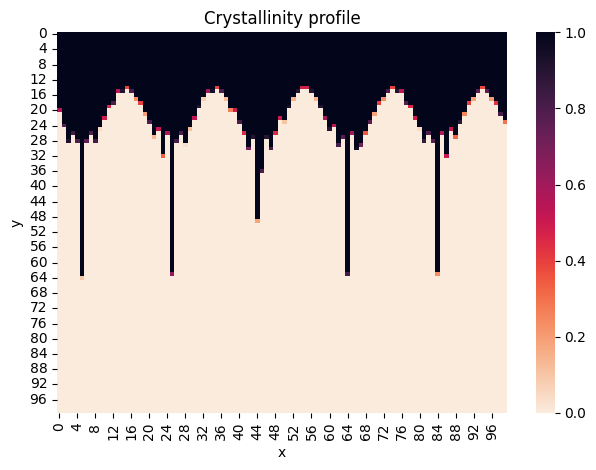

In [163]:
ax = sns.heatmap(phi_array, cmap = sns.cm.rocket_r)
#print(phi_array[21])
#print(phi0[21])
#print(delt*dphi_dt_array[21])
plt.title('Crystallinity profile')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

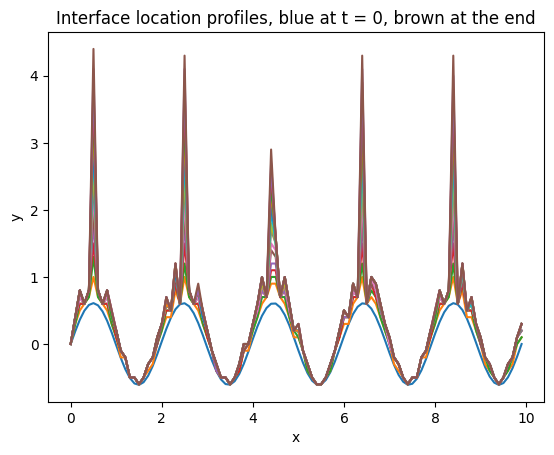

In [164]:
for elem in boundary[::10]:
    plt.title('Interface location profiles, blue at t = 0, brown at the end')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(x_position, np.array(elem) - 20*delx)#initial_boundary

So, it is clearly seen that solidification is faster at the crests. Note that we allow growth only in the forward direction, that's the reason why we have these unusually long spikes. We could do the following:
1. Allow lateral growth as well. It will result in creation of patterns rather than spikes.
2. Incrorporate surface tension. One way of doing it would be by implementing the curvature dependence of the melting temperature. For this, compute the local curvature everywhere and assign the melting temperature accordingly.
3. With surface tension included, there has to be a threshold wavelength below which the growth is stable. Explore this threshold as a function of various variables and compare with existing theories.
4. Explore the possibility of different pattern-morphologies and the physics behind them.

Below, I will do a quick check on how different Fourier modes evolve with time.

In [165]:
from scipy.fft import fft
import numpy as np
x = np.array([1.0, 2.0, 1.0, -1.0, 1.5])
y = fft(x)

In [166]:
y

array([ 4.5       -0.j        ,  2.08155948-1.65109876j,
       -1.83155948+1.60822041j, -1.83155948-1.60822041j,
        2.08155948+1.65109876j])

In [167]:
abs(y)**2

array([20.25      ,  7.05901699,  5.94098301,  5.94098301,  7.05901699])

100


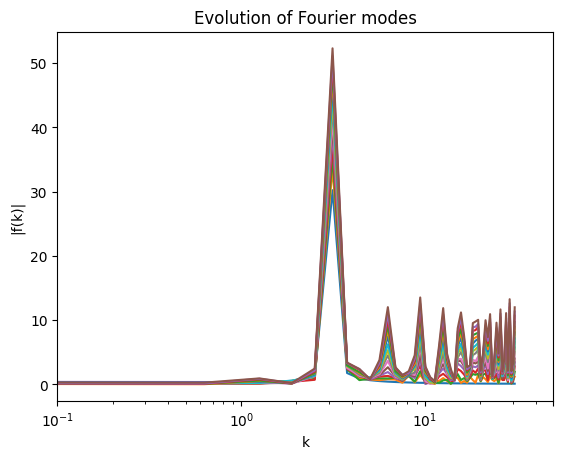

In [168]:
N = x_position.shape[0]
print(N)
x = x_position

#k_list = [(2*np.pi/L) * n for n in range(1, N+1)] # k has to be > 2*(2pi/L)
#print(k_list)
frequencies = 2*np.pi*np.fft.fftfreq(N, d=x[1]-x[0]) # I multiplied it by 2*pi to get the actual k
#print(frequencies)
for elem in boundary[::10]:
    fourier_transform = np.fft.fft(np.array(elem) - 20*delx)#20*delx)
    plt.plot(frequencies[:N//2], abs(fourier_transform)[:N//2])
    plt.xscale('log')
    #plt.yscale('symlog')
    plt.xticks([0.1, 1.0, 10, 50])
    #plt.xlim(xmin = -0.1)
    
    plt.title('Evolution of Fourier modes')
    plt.xlabel('k')
    plt.ylabel('|f(k)|')

There does not seem to be any visible k-dependence. This needs a systematic exploration. I would check the code once more before continuing to do more computation.

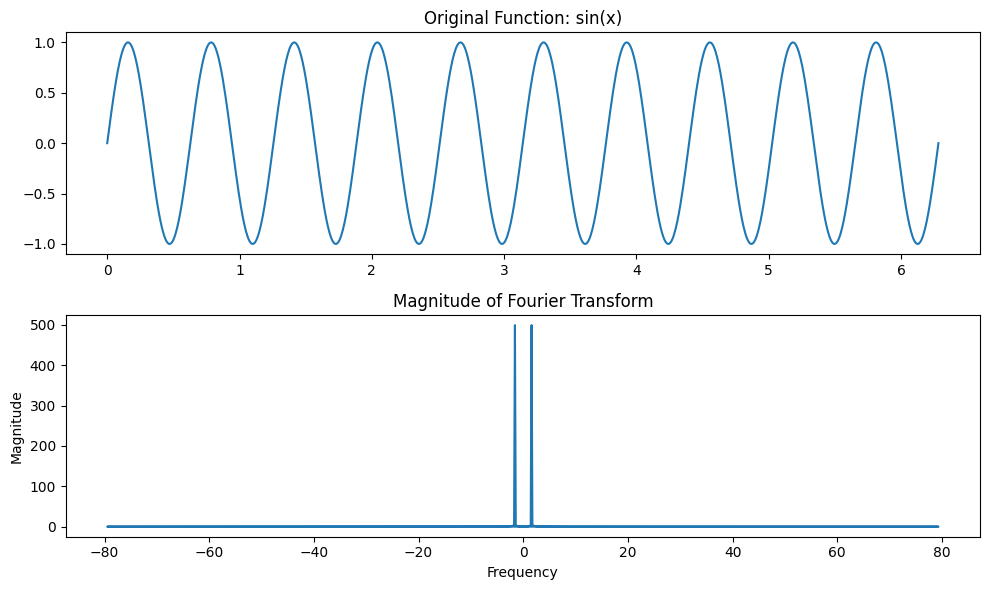

In [169]:
### You can ignore this - I am Fourier transforming sin[x] just to make sure what I did above is right

import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
N = 1000  # Number of data points
x = np.linspace(0, 2*np.pi, N)  # Time (or spatial) domain values
y = np.sin(10*x)  # Original function values

# Compute the Discrete Fourier Transform (DFT)
fft_result = np.fft.fft(y)

# Frequencies corresponding to the DFT components
frequencies = np.fft.fftfreq(N, d=x[1]-x[0])

# Plot the results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.title('Original Function: sin(x)')

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title('Magnitude of Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()
